# Dataset Research

# Global Library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sklearn
import ipywidgets as widgets
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# set matplotlib to display graphics in the notebook
%matplotlib inline

# Dataset Import

This section imports the diabetes dataset provided for the assignment. The dataset is saved in csv format in the same folder as the project notebook. The file is imported into the project as a pandas dataframe object.

In [2]:
# import dataset from csv
ml_dataset = pd.read_csv('./Synthetic_Data_For_Students.csv')

# confirm number of imported records matches expected size
print("Number of records imported: " + str(len(ml_dataset.index)))

Number of records imported: 5000


# Dataset Initial Exploration

## Display Dataset Summary Info

In [ ]:
ml_dataset.info()

All numeric columns are float64 type. 
All string columns are Object type.

There are null values in multiple columns, these will need to be handled appropriately. Discussion with the client has identified that null values in the settlement column indicate unsettled claims, so these should not be used in model training.


## Removal of unsettled claims entries

In [3]:
# remove rows where the settlement column is null
ml_dataset = ml_dataset.dropna(subset=['SettlementValue'])


## Display Column Value Ranges

In [ ]:
# display summary statistics for numerical columns
ml_dataset.describe()

## Show total values for each numerical column

In [ ]:
# for each numerical column, diplay the count of non-zero values
print("column - count of non-zero - sum of values - mean values (excluding zero rows)")
for column in ml_dataset.select_dtypes(include='float64'):
    print(column + " - " + str(ml_dataset[ml_dataset[column] != 0][column].count()) + " - " + str(ml_dataset[column].sum()) + " - " + str((ml_dataset[column].sum() / ml_dataset[ml_dataset[column] != 0][column].count())))



Looking at the values above, SpecialReduction can be ignored as there are no non-zero values.

SpecialRehabilitation can be ignored as it appears infrequently and contributes little to overall settlement amount (max value £21).

SpecialMedication can be ignored as it appears infrequently and contributes little to overall settlement amount (max value £30).

Accident Date and Claim date are not relevant to the claim outcome

Columns with a high maximum value but low mean are candidates for grouping and further analysis is required.

SpecialAdditionalInjury, SpecialFixes, SpecialHealthExpenses and SpecialLoanerVehicle could all be relevant groups, as they have low frequency but can be high value.

GeneralUplift - there are a small number of high values in this column

SpecialTripCosts and SpecialJourneyExpenses may be important - need to perform further analysis


Recommend investigating the relationship and correlations between the different types of columns (eg. can medical / trip+journey expenses be grouped)


## Removal of Columns

Along with the numerical columns identified above, Gender and age values should be dropped as they are protected characteristics and should not be used for training models due to the possibility of introducing bias into the model.

In [4]:
ml_dataset = ml_dataset.drop(columns=['SpecialReduction','SpecialRehabilitation','SpecialMedications','Driver Age','Gender','Accident Date','Claim Date'])

## Display the first x rows of the dataset using a slider widget

In [ ]:
widgets.interact(lambda x: ml_dataset.head(x), x=(widgets.IntSlider(min=5, max=50, step=5, value=5)))

# Data Preparation

## Show unique values for each text field

In [7]:
def display_text_values(col):
    print(col.name, 'Unique values:', col.unique())

In [8]:
for column in ml_dataset.select_dtypes(include='object'):
    display_text_values(ml_dataset[column])

AccidentType Unique values: ['Rear end' 'Other side pulled out of side road'
 'Rear end - Clt pushed into next vehicle'
 'Other side pulled on to roundabout' nan
 "Other side reversed into Clt's vehicle"
 "Other side changed lanes and collided with clt's vehicle" 'Other'
 "Other side turned across Clt's path"
 'Other side drove on wrong side of the road'
 "Other side changed lanes on a roundabout colliding with clt's vehicle"
 'Rear end - 3 car - Clt at front'
 "Other side reversed into clt's stationary vehicle"
 "Other side collided with Clt's parked vehicle"
 "Other side pulled from parked position into the path of clt's vehicle"
 "Other side opened their door, hitting clt's vehicle"
 'Other side overtook and hit Clt when pulling in'
 'Other side overtook and pulled in too soon'
 'Other side overtook whilst clt was turning right']
Injury_Prognosis Unique values: ['E. 5 months' 'B. 2 months' 'G. 7 months' 'D. 4 months' 'C. 3 months'
 'F. 6 months' nan 'H. 8 months' 'I. 9 months' 'A. 1

The InjuryPrognosis column should be converted to an integer value representing number of months

Exceptional_Circumstances, Minor_Psychological_Injury, Whiplash, Police Report Filed, Witness Present should be converted to binary value using one-hot, however handling of any null values must be addressed first. Most likely conclusion is that a blank field is treated as a no, however the claim entry form should use a drop down allowing only Yes or No, with a default value of No to prevent missing data in future records. Likewise for other input fields (weather, vehicle, injury type) these should offer a drop down selection menu, but be blank by default and input validation should prevent record creation without a value being entered.

Accident Date and Claim Date are unlikely to be relevant to the claim details, however the difference between these dates may be indicative of claim success due to difficulty in proving fault retrospectively. As such, a new column could be created showing the time elapsed between these dates.

Unless there are significant correlations to the settlement outcomes, retaining Injury description and dominant injury type is probably not needed, will perform analysis to determine which can be dropped. Likewise for accident type and accident description.

## Convert prognosis to integer
Prognosis is likely to be an important factor in determining the outcome. Initilly considered dropping the rows with NaN for prognosis, however some of the claims with NaN prognosis resulted in large payouts, so it may be important to keep the data. I suspect that once the remaining categorical data has been properly encoded or removed, then it will be possible to use a KNN imputer to fill in the prognosis column null values

In [9]:
# Extract numbers and convert to nullable integer type
ml_dataset['Injury_Prognosis'] = (
    ml_dataset['Injury_Prognosis']
    .str.extract('(\d+)', expand=False)
    .astype('Int64')
)
print(ml_dataset['Injury_Prognosis'].head(20))

0        5
1        2
2        7
3        4
4        3
5        6
6     <NA>
7        8
8        6
9        2
10       6
11       6
12       7
13       5
14       9
15       9
16       5
17       5
18       7
19       4
Name: Injury_Prognosis, dtype: Int64


## Check for Duplicate Rows

Duplicate rows contaminate the data and could skew the training process, negatively impacting prediction performance.

In [10]:
# calculate duplicates
duplicates = ml_dataset.duplicated()
# report duplicates
print(duplicates.any())
# list duplicate rows
print(ml_dataset[duplicates])

False
Empty DataFrame
Columns: [SettlementValue, AccidentType, Injury_Prognosis, SpecialHealthExpenses, SpecialOverage, GeneralRest, SpecialAdditionalInjury, SpecialEarningsLoss, SpecialUsageLoss, SpecialAssetDamage, SpecialFixes, GeneralFixed, GeneralUplift, SpecialLoanerVehicle, SpecialTripCosts, SpecialJourneyExpenses, SpecialTherapy, Exceptional_Circumstances, Minor_Psychological_Injury, Dominant injury, Whiplash, Vehicle Type, Weather Conditions, Vehicle Age, Number of Passengers, Accident Description, Injury Description, Police Report Filed, Witness Present]
Index: []

[0 rows x 29 columns]


*No Duplicate rows exist*

## Check for Negative Values

Negative values where they are not expected/possible would also affect the reliability of the analysis and should be removed prior to proceeding

In [11]:
# Check for negative values in all columns of Dataframe
for column in ml_dataset.select_dtypes(include='float64'):
    column = ml_dataset[column]
    # Get the count of negatives in column
    count = (column < 0).sum()
    print('Count of negative values in column ', column.name, ' is : ', count)

Count of negative values in column  SettlementValue  is :  0
Count of negative values in column  SpecialHealthExpenses  is :  0
Count of negative values in column  SpecialOverage  is :  0
Count of negative values in column  GeneralRest  is :  0
Count of negative values in column  SpecialAdditionalInjury  is :  0
Count of negative values in column  SpecialEarningsLoss  is :  0
Count of negative values in column  SpecialUsageLoss  is :  0
Count of negative values in column  SpecialAssetDamage  is :  0
Count of negative values in column  SpecialFixes  is :  0
Count of negative values in column  GeneralFixed  is :  0
Count of negative values in column  GeneralUplift  is :  0
Count of negative values in column  SpecialLoanerVehicle  is :  0
Count of negative values in column  SpecialTripCosts  is :  0
Count of negative values in column  SpecialJourneyExpenses  is :  0
Count of negative values in column  SpecialTherapy  is :  0
Count of negative values in column  Vehicle Age  is :  0
Count o

*No negative values exist*

## Convert numerical values to integers
Numerical columns are primarily money amounts so can be rounded to whole pounds - prediction amount does not require accuracy in pence

It doesn't make sense to have number of passengers as float

Age of car also does not need to be accurate to fractions of a year

In [12]:
for column in ml_dataset.select_dtypes(include='float64'):
    ml_dataset[column] = ml_dataset[column].round()
    ml_dataset[column] = ml_dataset[column].astype('Int64')

In [13]:
ml_dataset.head(20)

,SettlementValue,AccidentType,Injury_Prognosis,SpecialHealthExpenses,SpecialOverage,GeneralRest,SpecialAdditionalInjury,SpecialEarningsLoss,SpecialUsageLoss,SpecialAssetDamage,...,Dominant injury,Whiplash,Vehicle Type,Weather Conditions,Vehicle Age,Number of Passengers,Accident Description,Injury Description,Police Report Filed,Witness Present
0,520,Rear end,5,0,0,0,0,0,0,0,...,Arms,Yes,Motorcycle,Rainy,13,4,Side collision at an intersection.,Whiplash and minor bruises.,Yes,Yes
1,870,Rear end,2,0,0,520,0,0,90,0,...,Multiple,Yes,Motorcycle,Snowy,4,2,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes
2,2140,Other side pulled out of side road,7,0,0,1400,0,0,0,0,...,Legs,Yes,Motorcycle,Sunny,9,4,Lost control on a snowy road.,Whiplash and minor bruises.,Yes,No
3,520,Rear end - Clt pushed into next vehicle,4,0,0,0,0,0,0,0,...,Arms,Yes,Truck,Rainy,5,1,Side collision at an intersection.,Minor cuts and scrapes.,Yes,Yes
4,260,Rear end,3,0,0,0,0,0,0,0,...,Arms,No,Motorcycle,Rainy,9,1,Lost control on a snowy road.,Concussion and bruised ribs.,Yes,Yes
5,520,Rear end,6,0,0,0,0,0,0,0,...,Multiple,Yes,Car,Rainy,10,1,Lost control on a snowy road.,Minor cuts and scrapes.,Yes,No
6,1015,Rear end,<NA>,0,0,0,0,0,0,9,...,Legs,Yes,Motorcycle,Sunny,5,1,Hit a deer on the highway.,Whiplash and minor bruises.,No,No
7,1032,Other side pulled out of side road,8,0,0,0,0,0,0,0,...,Legs,Yes,Car,Sunny,9,4,Side collision at an intersection.,Concussion and bruised ribs.,No,Yes
8,808,Rear end,6,0,0,0,0,0,0,0,...,Arms,No,Motorcycle,Snowy,13,4,Swerved to avoid another vehicle.,Minor cuts and scrapes.,Yes,Yes
9,500,Rear end,2,0,0,0,0,0,0,0,...,Hips,Yes,Motorcycle,Rainy,19,4,Rear-ended at a stoplight.,Minor cuts and scrapes.,Yes,Yes


## Check for mutual information between categorical string columns and settlement value and injury prognosis

In [14]:
# use mutual_info_regression to calculate the mutual information between the target column and each feature column
min_max_scaler = MinMaxScaler()

def check_mutual_info(df, target_col, feature_col):
    temp_df = df[[target_col, feature_col]]
    temp_df = temp_df.dropna()

    count = 0
    mutual_info = mutual_info_regression(temp_df[[feature_col]], temp_df[target_col])
    if mutual_info > 0.05:
        print(f'Mutual Information between {target_col} and {feature_col}: {mutual_info}')
        count += 1
    else:
        pass
        ## print(f'Mutual Information between {target_col} and {feature_col} not statistically significant: {mutual_info}')
    return count

In [15]:
cat_cols = ['Dominant injury','Vehicle Type','Weather Conditions','Injury Description','Accident Description','AccidentType']
for col in cat_cols:
    temp_df = ml_dataset[['SettlementValue','Injury_Prognosis',col]]
    # one hot encode the categorical column
    temp_df = pd.get_dummies(temp_df, columns=[col])
    temp_df = temp_df.dropna()
    # normalize the numerical columns
    min_max_scaler = MinMaxScaler()
    temp_df[['SettlementValue','Injury_Prognosis']] = min_max_scaler.fit_transform(temp_df[['SettlementValue','Injury_Prognosis']])
    # print('temp_df for col:', col)
    # print(temp_df.head())
    # display correlation matrix for temp_df
    count = 0
    # print('Mutual Info Calculations for categorical column:', col)
    for cat_col in temp_df.columns:
        if cat_col != 'SettlementValue' and cat_col != 'Injury_Prognosis':
            count += check_mutual_info(temp_df, 'SettlementValue', cat_col)
            count += check_mutual_info(temp_df, 'Injury_Prognosis', cat_col)
    #display(temp_df.corr())
    if count == 0:
        print('No Mutual Information found for column:', col)
    # check_correlation(temp_df, 'SettlementValue', col)
    # check_correlation(temp_df, 'Injury_Prognosis', col)

No Mutual Information found for column: Dominant injury
No Mutual Information found for column: Vehicle Type
No Mutual Information found for column: Weather Conditions
No Mutual Information found for column: Injury Description
No Mutual Information found for column: Accident Description
Mutual Information between SettlementValue and AccidentType_Other: [0.07736541]
Mutual Information between SettlementValue and AccidentType_Other side changed lanes and collided with clt's vehicle: [0.05034136]
Mutual Information between SettlementValue and AccidentType_Other side pulled out of side road: [0.12211744]
Mutual Information between SettlementValue and AccidentType_Other side turned across Clt's path: [0.07858702]
Mutual Information between SettlementValue and AccidentType_Rear end: [0.2341441]
Mutual Information between SettlementValue and AccidentType_Rear end - Clt pushed into next vehicle: [0.05951386]


Only the AccidentType column appears to have any values correlated with the SettlementValue column, so the others will be removed

## Remove category columns that are not correlated

In [16]:
ml_dataset = ml_dataset.drop(columns=['Dominant injury','Injury Description','Weather Conditions','Vehicle Type','Accident Description'])

## Histogram Visualisation

In [ ]:
# display histogram of numerical columns plotting only non-zero values against the settlement column
for column in ml_dataset.select_dtypes(include='Int64'):
    sns.histplot(ml_dataset[ml_dataset[column] != 0][column])
    plt.title(column)
    plt.show()

## Display Null Value Counts

Null values indicate missing data and impact a feature column's usefulness in the training process

In [17]:
# find nulls
ml_dataset.isnull().sum()

SettlementValue                 0
AccidentType                  111
Injury_Prognosis              146
SpecialHealthExpenses         117
SpecialOverage                109
GeneralRest                   119
SpecialAdditionalInjury       126
SpecialEarningsLoss           114
SpecialUsageLoss              121
SpecialAssetDamage            102
SpecialFixes                  112
GeneralFixed                  114
GeneralUplift                 126
SpecialLoanerVehicle          130
SpecialTripCosts              108
SpecialJourneyExpenses        136
SpecialTherapy                126
Exceptional_Circumstances      97
Minor_Psychological_Injury    107
Whiplash                      123
Vehicle Age                   118
Number of Passengers          115
Police Report Filed             0
Witness Present                 0
dtype: int64

There are significant numbers of null values across the dataset, and most likely removing all of them would drastically reduce the number of rows, negatively impact model training. An approach is needed to identify which feature columns are correlated with the settlement value before determining how to proceed with NaN values in any column.

## Visualise correlations

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

# def check_correlation(df, target_col, feature_col):
#     temp_df = df[[target_col, feature_col]]
#     temp_df = temp_df.dropna()

#     min_max_scaler = MinMaxScaler()
#     df[[target_col, feature_col]] = min_max_scaler.fit_transform(df[[target_col, feature_col]])

#     correlation = temp_df[target_col].corr(df[feature_col])
#     if correlation > 0.5 or correlation < -0.5:
#         print(f'Correlation between {target_col} and {feature_col}: {correlation}')
#     elif correlation > 0.95 or correlation < -0.95:
#         print(f'Redundant Correlation between {target_col} and {feature_col}: {correlation}')
#     else:
#         print(f'Correlation between {target_col} and {feature_col} not statistically significant: {correlation}')
        

In [ ]:
ml_dataset.head()

In [ ]:
for column in ml_dataset:
    if column != 'SettlementValue' and ml_dataset[column].dtype != 'object':
            for column2 in ml_dataset:
                if column2 != (column or 'SettlementValue') and ml_dataset[column2].dtype != 'object':
                    check_correlation(ml_dataset, column, column2)


## Convert simple binary columns
Replace binary column text to int and convert NaNs to 0

Columns to convert:

Exceptional_Circumstances, Minor_Psychological_Injury, Whiplash, Police Report Filed, Witness Present

In [18]:
def binary_encode(df, column, positive_value):
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    df[column] = df[column].astype('Int8')
    return df

In [19]:
binary_cols = ['Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Whiplash', 'Police Report Filed', 'Witness Present']
for col in binary_cols:
    ml_dataset = binary_encode(ml_dataset, col, 'Yes')

In [20]:
ml_dataset.head(50)

,SettlementValue,AccidentType,Injury_Prognosis,SpecialHealthExpenses,SpecialOverage,GeneralRest,SpecialAdditionalInjury,SpecialEarningsLoss,SpecialUsageLoss,SpecialAssetDamage,...,SpecialTripCosts,SpecialJourneyExpenses,SpecialTherapy,Exceptional_Circumstances,Minor_Psychological_Injury,Whiplash,Vehicle Age,Number of Passengers,Police Report Filed,Witness Present
0,520,Rear end,5,0,0,0,0,0,0,0,...,0,0,0,0,1,1,13,4,1,1
1,870,Rear end,2,0,0,520,0,0,90,0,...,0,0,0,0,1,1,4,2,1,1
2,2140,Other side pulled out of side road,7,0,0,1400,0,0,0,0,...,0,0,0,0,0,1,9,4,1,0
3,520,Rear end - Clt pushed into next vehicle,4,0,0,0,0,0,0,0,...,0,0,0,0,1,1,5,1,1,1
4,260,Rear end,3,0,0,0,0,0,0,0,...,0,0,0,0,1,0,9,1,1,1
5,520,Rear end,6,0,0,0,0,0,0,0,...,0,0,0,0,1,1,10,1,1,0
6,1015,Rear end,<NA>,0,0,0,0,0,0,9,...,31,<NA>,455,0,1,1,5,1,0,0
7,1032,Other side pulled out of side road,8,0,0,0,0,0,0,0,...,0,0,192,0,0,1,9,4,0,1
8,808,Rear end,6,0,0,0,0,0,0,0,...,0,65,400,0,1,0,13,4,1,1
9,500,Rear end,2,0,0,0,0,0,0,0,...,0,0,275,0,1,1,19,4,1,1


## Fill NaN values in numeric columns with zero
As Injury prognosis, Number of passengers and age of vehicle could be significant in determining the settlement value, the NaN rows will be removed until further analysis has determined whether they should be imputed based on other rows, replaced with a fixed value or dropped altogether


## Imputing NaN text fields to No

In [ ]:
# for column in ml_dataset.select_dtypes(include=[object]):
#     ml_dataset[column] = ml_dataset[column].fillna('No')

In [21]:
for column in ml_dataset.select_dtypes(include='Int64'):
    ml_dataset[column] = ml_dataset[column].fillna(0)

In [22]:
ml_dataset.isnull().sum()

SettlementValue                 0
AccidentType                  111
Injury_Prognosis                0
SpecialHealthExpenses           0
SpecialOverage                  0
GeneralRest                     0
SpecialAdditionalInjury         0
SpecialEarningsLoss             0
SpecialUsageLoss                0
SpecialAssetDamage              0
SpecialFixes                    0
GeneralFixed                    0
GeneralUplift                   0
SpecialLoanerVehicle            0
SpecialTripCosts                0
SpecialJourneyExpenses          0
SpecialTherapy                  0
Exceptional_Circumstances       0
Minor_Psychological_Injury      0
Whiplash                        0
Vehicle Age                     0
Number of Passengers            0
Police Report Filed             0
Witness Present                 0
dtype: int64

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.feature_selection import mutual_info_regression, SelectKBest, RFE
# from sklearn.linear_model import LinearRegression
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import seaborn as sns
# import matplotlib.pyplot as plt
# import scipy.sparse as sparse
# from tqdm import tqdm
# from time import time
# import sys

# def log(message):
#     print(f"[{time():.1f}] {message}")
#     sys.stdout.flush()

# # Load dataset
# log("Initializing pipeline...")
# df = pd.read_csv('./Synthetic_Data_For_Students.csv')
# y = df['SettlementValue']
# X = df.drop('SettlementValue', axis=1)

# # Identify column types
# numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
# categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# # Configure preprocessing with name preservation
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='median')),
#             ('scaler', StandardScaler())
#         ]), numerical_cols),
#         ('cat', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('encoder', OneHotEncoder(
#                 handle_unknown='ignore',
#                 sparse_output=True,
#                 feature_name_combiner=lambda feature, category: f"{feature}_{category}"
#             ))
#         ]), categorical_cols)
#     ],
#     verbose_feature_names_out=False,
#     remainder='drop'
# )

# # Feature selection pipeline with validated dimensions
# feature_selector = Pipeline([
#     ('preprocessor', preprocessor),
#     ('kbest', SelectKBest(score_func=mutual_info_regression, k=15)),
#     ('rfe', RFE(LinearRegression(), n_features_to_select=10))
# ])

# def analyze_features(X_transformed, feature_names):
#     log("Starting feature analysis")
    
#     # Convert to dense array with NaN handling
#     if sparse.issparse(X_transformed):
#         log("Converting sparse matrix to dense...")
#         X_dense = X_transformed.astype(float).toarray()
#     else:
#         X_dense = X_transformed.astype(float)
        
#     df = pd.DataFrame(X_dense, columns=feature_names)
    
#     # Handle remaining NaNs
#     nan_count = df.isna().sum().sum()
#     if nan_count > 0:
#         log(f"Imputing {nan_count} NaN values...")
#         df = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(df),
#                          columns=feature_names)
    
#     # Remove zero-variance features
#     valid_features = df.columns[df.nunique() > 1].tolist()
#     df = df[valid_features]
    
#     # Correlation analysis
#     log("Calculating correlations...")
#     corr_matrix = df.corr()
#     plt.figure(figsize=(12,10))
#     sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
#     plt.title('Feature Correlation Matrix')
#     plt.show()
    
#     # VIF calculation with progress
#     log("Calculating VIF scores...")
#     vif_data = pd.DataFrame({'feature': valid_features})
#     vif_values = []
    
#     for i in tqdm(range(len(valid_features)), desc="VIF Calculation"):
#         try:
#             vif = variance_inflation_factor(df.values.astype(float), i)
#             vif_values.append(vif)
#         except Exception as e:
#             log(f"Error in {valid_features[i]}: {str(e)}")
#             vif_values.append(np.nan)
    
#     vif_data['VIF'] = vif_values
#     print("VIF Results:\n", vif_data.sort_values('VIF', ascending=False))

# # Execute preprocessing
# log("Preprocessing data...")
# X_preprocessed = preprocessor.fit_transform(X)

# # Generate valid feature names
# feature_names = (
#     numerical_cols + 
#     preprocessor.named_transformers_['cat']
#     .named_steps['encoder']
#     .get_feature_names_out(categorical_cols).tolist()
# )

# # Feature analysis
# log("Performing feature analysis...")
# analyze_features(X_preprocessed, feature_names)

# # Mutual information with enhanced NaN handling
# log("Preparing for mutual information...")
# if y.isna().any():
#     log("Imputing target variable...")
#     y = y.fillna(y.median())

# X_mi = X_preprocessed.astype(float)
# if sparse.issparse(X_mi):
#     X_mi = X_mi.toarray()
    
# if np.isnan(X_mi).any():
#     log("Cleaning feature NaNs...")
#     X_mi = SimpleImputer(strategy='median').fit_transform(X_mi)

# log("Calculating mutual information...")
# mi_scores = mutual_info_regression(X_mi, y, random_state=42, n_jobs=-1)
# mi_df = pd.DataFrame({'feature': feature_names, 'mi_score': mi_scores}) \
#          .sort_values('mi_score', ascending=False)
# plt.figure(figsize=(10,6))
# sns.barplot(x='mi_score', y='feature', data=mi_df.head(15))
# plt.title('Top Features by Mutual Information')
# plt.show()

# # Feature selection execution
# log("Starting feature selection...")
# feature_selector.fit(X, y)

# # Get final features with validated names
# log("Resolving feature names...")
# preprocessed_features = (
#     numerical_cols + 
#     preprocessor.named_transformers_['cat']
#     .named_steps['encoder']
#     .get_feature_names_out(categorical_cols).tolist()
# )

# selected_features = feature_selector.named_steps['kbest'] \
#     .get_feature_names_out(input_features=preprocessed_features)

# final_features = feature_selector.named_steps['rfe'] \
#     .get_feature_names_out(input_features=selected_features)

# print("\nFinal Selected Features:")
# print(pd.DataFrame(final_features, columns=['Features']))

# # Generate processed dataset
# log("Creating final dataset...")
# X_processed = pd.DataFrame(
#     feature_selector.transform(X),
#     columns=final_features
# )

# log("Pipeline execution completed successfully.")


[1742489998.0] Starting preprocessing pipeline...
[1742489998.1] Preprocessing completed (took 0.0s)
[1742489998.1] Building feature names...
[1742489998.1] Error getting categorical features: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.
[1742489998.1] Total features after preprocessing: 22
[1742489998.1] Starting feature analysis...
[1742489998.1] Starting feature analysis
[1742489998.1] Using existing dense matrix...
[1742489998.1] DataFrame shape after conversion: (4894, 22) (took 0.0s)
[1742489998.1] Checking for zero-variance features...
[1742489998.1] Removed 0 constant features (took 0.0s)
[1742489998.1] Calculating correlation matrix...
[1742489998.1] Correlation matrix calculated (took 0.0s)
[1742489998.1] Plotting heatmap...


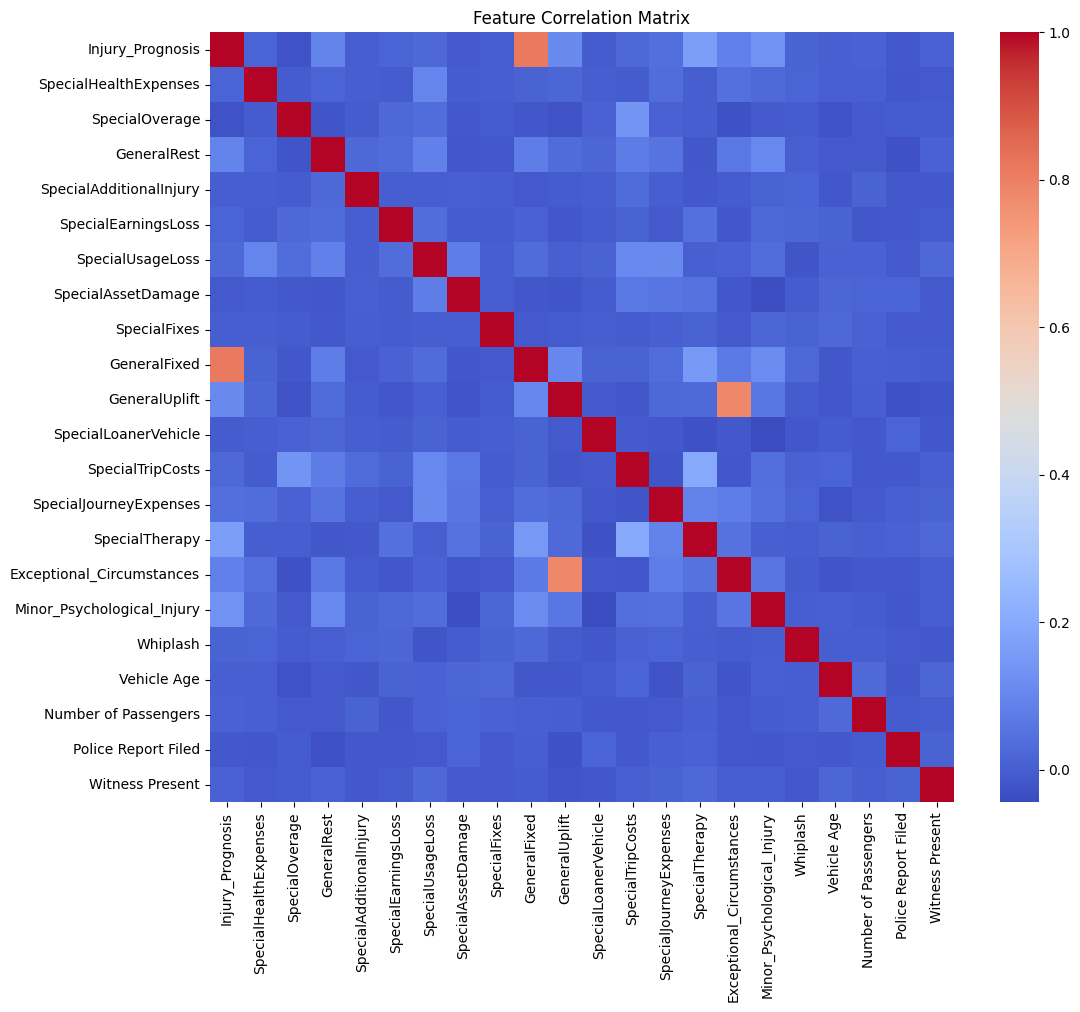

[1742489998.8] Heatmap displayed
[1742489998.8] Starting VIF calculations...


VIF Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 64.35it/s]

[1742489999.1] Completed VIF calculations (took 0.3s)
Variance Inflation Factors:
                        feature       VIF
0             Injury_Prognosis  3.016724
9                 GeneralFixed  2.984739
15   Exceptional_Circumstances  2.612890
10               GeneralUplift  2.601325
14              SpecialTherapy  1.092852
12            SpecialTripCosts  1.092420
6             SpecialUsageLoss  1.048949
3                  GeneralRest  1.040112
13      SpecialJourneyExpenses  1.039971
16  Minor_Psychological_Injury  1.036668
2               SpecialOverage  1.026256
7           SpecialAssetDamage  1.017679
1        SpecialHealthExpenses  1.014575
5          SpecialEarningsLoss  1.007143
18                 Vehicle Age  1.006325
11        SpecialLoanerVehicle  1.005492
21             Witness Present  1.004103
20         Police Report Filed  1.003985
4      SpecialAdditionalInjury  1.003323
17                    Whiplash  1.003288
19        Number of Passengers  1.002610
8              

[1742489999.5] Mutual info calculated (took 0.3s)


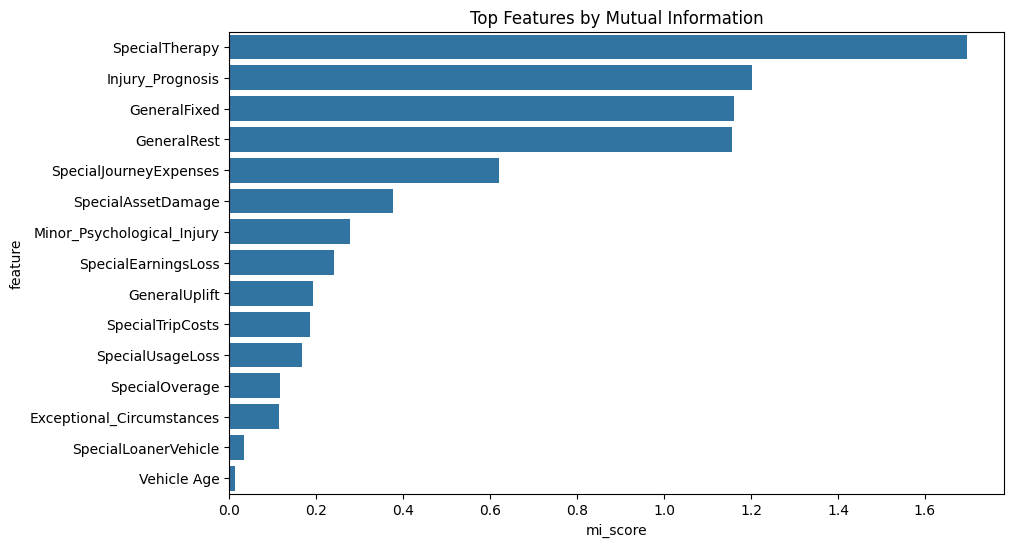

[1742489999.9] Starting feature selection pipeline...
[1742489999.9] Fit preprocessing and SelectKBest...
[1742490001.0] Completed feature selection
[1742490001.0] Feature selection completed (total time 1.1s)
Selected features: ['num__Injury_Prognosis' 'num__SpecialHealthExpenses'
 'num__SpecialOverage' 'num__GeneralRest' 'num__SpecialEarningsLoss'
 'num__SpecialUsageLoss' 'num__SpecialAssetDamage' 'num__GeneralFixed'
 'num__GeneralUplift' 'num__SpecialLoanerVehicle' 'num__SpecialTripCosts'
 'num__SpecialJourneyExpenses' 'num__SpecialTherapy'
 'num__Exceptional_Circumstances' 'num__Minor_Psychological_Injury']

Processed dataframe preview:
   num__Injury_Prognosis  num__SpecialHealthExpenses  num__SpecialOverage  \
0              -0.318013                   -0.042367            -0.157114   
1              -1.351219                   -0.042367            -0.157114   
2               0.370792                   -0.042367            -0.157114   
3              -0.662415                   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression, SelectKBest, RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from tqdm import tqdm
from time import time
import sys

def log(message):
    print(f"[{time():.1f}] {message}")
    sys.stdout.flush()

# Load dataset
# log("Loading dataset...")
# df = pd.read_csv('./Synthetic_Data_For_Students.csv')
df = ml_dataset
y = df['SettlementValue']
X = df.drop(['SettlementValue', 'AccidentType'], axis=1)

# Identify column types
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True, max_categories=10))
    ]), categorical_cols)
])

# Feature selection pipeline
# Feature selection pipeline
feature_selector = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=mutual_info_regression, k=15))
    # RFE removed as it was causing feature name mismatches
])
def analyze_features(X_transformed, feature_names):
    log("Starting feature analysis")
    
    # Conversion to dense array
    start_time = time()
    if sparse.issparse(X_transformed):
        log("Converting sparse matrix to dense array...")
        X_dense = X_transformed.toarray()
        df = pd.DataFrame(X_dense, columns=feature_names)
    else:
        log("Using existing dense matrix...")
        df = pd.DataFrame(X_transformed, columns=feature_names)
    log(f"DataFrame shape after conversion: {df.shape} (took {time()-start_time:.1f}s)")

    # Remove zero-variance features
    start_time = time()
    log("Checking for zero-variance features...")
    df = df.loc[:, df.nunique() > 1]
    valid_features = df.columns.tolist()
    log(f"Removed {len(feature_names)-len(valid_features)} constant features (took {time()-start_time:.1f}s)")

    # Correlation matrix
    if len(valid_features) > 0:
        log("Calculating correlation matrix...")
        start_time = time()
        corr_matrix = df.corr()
        log(f"Correlation matrix calculated (took {time()-start_time:.1f}s)")
        
        log("Plotting heatmap...")
        plt.figure(figsize=(12,10))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
        plt.title('Feature Correlation Matrix')
        plt.show()
        log("Heatmap displayed")
    else:
        print("No valid features for correlation analysis")
        return

    # VIF calculation
    log("Starting VIF calculations...")
    vif_data = pd.DataFrame()
    vif_data["feature"] = valid_features
    vif_values = []
    
    start_time = time()
    for i in tqdm(range(len(valid_features)), desc="VIF Progress"):
        try:
            vif = variance_inflation_factor(df.values.astype(float), i)
            vif_values.append(vif)
        except Exception as e:
            log(f"Error calculating VIF for {valid_features[i]}: {str(e)}")
            vif_values.append(np.nan)
    
    log(f"Completed VIF calculations (took {time()-start_time:.1f}s)")
    vif_data["VIF"] = vif_values
    print("Variance Inflation Factors:\n", vif_data.sort_values('VIF', ascending=False))

# Execute pipeline
log("Starting preprocessing pipeline...")
start_time = time()
X_preprocessed = preprocessor.fit_transform(X)
log(f"Preprocessing completed (took {time()-start_time:.1f}s)")

log("Building feature names...")
feature_names = numerical_cols.copy()
try:
    cat_features = preprocessor.named_transformers_['cat']\
                   .named_steps['encoder']\
                   .get_feature_names_out(categorical_cols).tolist()
    feature_names += cat_features
    log(f"Added {len(cat_features)} categorical features")
except Exception as e:
    log(f"Error getting categorical features: {str(e)}")

log(f"Total features after preprocessing: {len(feature_names)}")

# Feature relationship analysis
log("Starting feature analysis...")
analyze_features(X_preprocessed, feature_names)

# Mutual information scores
# Modify the mutual information calculation section as follows:

# Mutual information scores
log("Checking for NaNs in target variable...")
if y.isna().any():
    log(f"Found {y.isna().sum()} NaN values in target variable 'y', imputing with median...")
    y = y.fillna(y.median())
    log("Target variable NaN handling completed")

log("Verifying preprocessed data...")
if sparse.issparse(X_preprocessed):
    X_dense_mi = X_preprocessed.astype(float).toarray()
else:
    X_dense_mi = X_preprocessed.astype(float)
    
if np.isnan(X_dense_mi).any():
    log("Found NaN in preprocessed features, imputing...")
    from sklearn.impute import SimpleImputer
    X_dense_mi = SimpleImputer(strategy='median').fit_transform(X_dense_mi)
    log("Feature matrix NaN handling completed")

log("Calculating mutual information scores...")
start_time = time()
with np.errstate(divide='ignore', invalid='ignore'):
    mi_scores = mutual_info_regression(
        X_dense_mi,
        y,
        random_state=42,
        n_jobs=-1
    )
log(f"Mutual info calculated (took {time()-start_time:.1f}s)")


mi_df = pd.DataFrame({'feature': feature_names, 'mi_score': mi_scores}) \
         .sort_values('mi_score', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='mi_score', y='feature', data=mi_df.head(15))
plt.title('Top Features by Mutual Information')
plt.show()

# Feature selection
# Feature selection
log("Starting feature selection pipeline...")
start_time = time()

log("Fit preprocessing and SelectKBest...")
feature_selector.fit(X, y)  # Fit the entire pipeline
log("Completed feature selection")

log(f"Feature selection completed (total time {time()-start_time:.1f}s)")

# Get the feature names directly from the fitted pipeline
try:
    # Get the feature names after preprocessing
    preprocessed_features = feature_selector.named_steps['preprocessor'].get_feature_names_out()
    
    # Get the selected features
    selected_mask = feature_selector.named_steps['feature_selection'].get_support()
    final_features = preprocessed_features[selected_mask]
    
    print(f"Selected features: {final_features}")
except Exception as e:
    log(f"Error getting feature names: {str(e)}")
    # Fallback method if the above fails
# Get processed dataframe
X_processed = pd.DataFrame(
    feature_selector.transform(X),
    columns=final_features
)

# Display the first few rows of the processed dataframe
print("\nProcessed dataframe preview:")
print(X_processed.head())
X_processed = pd.DataFrame(feature_selector.transform(X),
                          columns=final_features)

log("Analysis complete.")



## Display count of zero values for all columns

Zero values are often used as placeholders for null values, so any row containing a zero value should be validated to determine if it is appropriate.

In [27]:
X_processed.head()

,num__Injury_Prognosis,num__SpecialHealthExpenses,num__SpecialOverage,num__GeneralRest,num__SpecialEarningsLoss,num__SpecialUsageLoss,num__SpecialAssetDamage,num__GeneralFixed,num__GeneralUplift,num__SpecialLoanerVehicle,num__SpecialTripCosts,num__SpecialJourneyExpenses,num__SpecialTherapy,num__Exceptional_Circumstances,num__Minor_Psychological_Injury
0,-0.318013,-0.042367,-0.157114,-0.593240,-0.129627,-0.136586,-0.116442,-0.370452,-0.204772,-0.054328,-0.147813,-0.233927,-0.80534,-0.257354,0.602687
1,-1.351219,-0.042367,-0.157114,0.090235,-0.129627,1.245143,-0.116442,-1.007154,-0.204772,-0.054328,-0.147813,-0.233927,-0.80534,-0.257354,0.602687
2,0.370792,-0.042367,-0.157114,1.246886,-0.129627,-0.136586,-0.116442,0.413180,-0.204772,-0.054328,-0.147813,-0.233927,-0.80534,-0.257354,-1.659237
3,-0.662415,-0.042367,-0.157114,-0.593240,-0.129627,-0.136586,-0.116442,-0.370452,-0.204772,-0.054328,-0.147813,-0.233927,-0.80534,-0.257354,0.602687
4,-1.006817,-0.042367,-0.157114,-0.593240,-0.129627,-0.136586,-0.116442,-1.007154,-0.204772,-0.054328,-0.147813,-0.233927,-0.80534,-0.257354,0.602687


In [28]:
# train simple linear regression model to predict settlement value
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 118428.88872045637


In [ ]:
# Count number of zeros in all columns of Dataframe
for column_name in ml_dataset.columns:
    column = ml_dataset[column_name]
    # Get the count of Zeros in column
    count = (column == 0).sum()
    print('Count of zeros in column ', column_name, ' is : ', count)

KeyError: 'num__Injury_Prognosis'

## Impute Missing Values

### Convert zero values to NaN

In [ ]:
# display describe summary table to confirm the changes
ml_dataset.describe()

### Impute mean average

In [ ]:
# # replace NaN values with mean value for the SkinThickness column
# ml_dataset["SkinThickness"] = ml_dataset["SkinThickness"].fillna((ml_dataset["SkinThickness"].mean())).round(2)

# # display column summary to confirm changes
# ml_dataset["SkinThickness"].describe()

### Impute using KNN

In [ ]:
# from sklearn.impute import KNNImputer

# # create a KNN imputer object
# imputer = KNNImputer(n_neighbors=5)

# # impute missing values using KNN for specified columns
# columns = ['Glucose','BloodPressure','BMI']
# for col in columns:
#     temp_df = pd.DataFrame(ml_dataset[col])
#     ml_dataset[col] = pd.DataFrame(imputer.fit_transform(temp_df)).round(2)

# ml_dataset.describe()


## Outlier Detection

### The following section is retained for reference only, as applying outlier removal to the dataset ultimately reduced performance of the trained model. Code relating to inspecting the outliers has been left intact, but all code relating to removal of outlier data has been commented out to prevent it from impacting model training.

Outlier detection is useful to remove datapoints that may disproportionately affect the model training

### Extreme Value Analysis
Calculate the interquartile range (IQR)

IQR (Inter quantiles range)= 75th quantile — 25th quantile

An outlier will be in the following upper and lower boundaries:
- Upper Boundary = 75th quantile +(IQR * 1.5)
- Lower Boundary = 25th quantile — (IQR * 1.5)

Or for extreme cases:
- Upper Boundary = 75th quantile +(IQR * 3)
- Lower Boundary = 25th quantile — (IQR * 3)

If the data point is above the upper boundary or below the lower boundary, it can be considered as an outlier.

In [ ]:
# # function to calculate inter-quartile ranges for a given column
# def calc_iqr(column):
#     temp_df = pd.DataFrame(ml_dataset[column])

#     # calculate inter-quartile range
#     IQR = (temp_df.quantile(0.75) - temp_df.quantile(0.25)).round(3)

#     # Calculate lower limit and lower limit extreme
#     lower_limit = (temp_df.quantile(0.25) - (IQR * 1.5)).round(3)
#     lower_limit_extreme = (temp_df.quantile(0.25) - (IQR * 3)).round(3)

#     # prevent negative numbers being evaluated
#     lower_limit[lower_limit < 0] = 0
#     lower_limit_extreme[lower_limit_extreme < 0] = 0

#     # get lower boundary and lower boundary extreme from the dataframe
#     compare_lower = lower_limit.iloc[0]
#     compare_lower_ex = lower_limit_extreme.iloc[0]

#     # compare the column data with the boundary value
#     lower_criteria = temp_df[(temp_df.iloc[:,0]) < compare_lower]
#     lower_ex_criteria = temp_df[(temp_df.iloc[:,0]) < compare_lower_ex]

#     # Calculate upper limit and upper limit extreme
#     upper_limit = (temp_df.quantile(0.75) + (IQR * 1.5)).round(3)
#     upper_limit_extreme = (temp_df.quantile(0.75) + (IQR * 3)).round(3)

#     # get upper boundary and upper boundary extreme from the dataframe
#     compare_upper = upper_limit.iloc[0]
#     compare_upper_ex = upper_limit_extreme.iloc[0]

#     # compare the column data with the boundary value
#     upper_criteria = temp_df[(temp_df.iloc[:,0]) > compare_upper]
#     upper_ex_criteria = temp_df[(temp_df.iloc[:,0]) > compare_upper_ex]

#     # display results of the calculations
#     print('\nTotal participants:',temp_df.size)
#     print(column, 'Inter-Quartile Range (IQR) = ', IQR[0])

#     print('\n', column, 'Lower Limit = ', lower_limit[0])
#     print('Participants with', column, 'below Lower Limit:', lower_criteria.size)

#     print('\n', column, 'Lower Limit Extreme = ', lower_limit_extreme[0])
#     print('Participants with', column, 'below Lower Limit Extreme:', lower_ex_criteria.size)

#     print('\n', column, 'Upper Limit = ', upper_limit[0])
#     print('Participants with', column, 'above Upper Limit:', upper_criteria.size)

#     print('\n', column, 'Upper Limit Extreme = ', upper_limit_extreme[0])
#     print('Participants with', column, 'above Upper Limit Extreme:', upper_ex_criteria.size)

In [ ]:
# # widget to display IQR values for the column selected in a drop-down box
# widgets.interact(lambda column: calc_iqr(column), column=['Age','Pregnancies','Glucose','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction'])

### Removal of Extreme Outliers

Remove extreme outliers identified in the previous section

*The following code section is commented out to prevent data removal*

In [ ]:
# ml_dataset_ex_outs = ml_dataset

# index = ml_dataset[(ml_dataset['SkinThickness'] > 53)].index
# ml_dataset_ex_outs.drop(index, inplace=True)

# index = ml_dataset[(ml_dataset['BMI'] > 63.90)].index
# ml_dataset_ex_outs.drop(index, inplace=True)

# index = ml_dataset[(ml_dataset['DiabetesPedigreeFunction'] > 1.77375)].index
# ml_dataset_ex_outs.drop(index, inplace=True)


### Visualizing Outliers

Using a box plot is a quick method of visualizing outliers

In [ ]:
# # sns.boxplot(y='annual_inc', data = data)
# widgets.interact(lambda X: sns.boxplot(data=ml_dataset, x=X), X=['Pregnancies','Glucose','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction','Age'])


### List Outliers Based on Limits Identifed in the Boxplot

In [ ]:
# print(ml_dataset[(ml_dataset['SkinThickness'] > 80)].index)
# print(ml_dataset[(ml_dataset['Age'] > 65)].index)
# print(ml_dataset[(ml_dataset['BMI'] > 50)].index)
# print(ml_dataset[(ml_dataset['BloodPressure'] > 105)].index)
# print(ml_dataset[(ml_dataset['BloodPressure'] < 40)].index)
# print(ml_dataset[(ml_dataset['Pregnancies'] > 13)].index)

### Outlier Removal Based on Boxplot

*This section is commented out to prevent data removal*

In [ ]:
# index = ml_dataset[(ml_dataset['SkinThickness'] > 80)].index
# ml_dataset.drop(index, inplace=True)

# index = ml_dataset[(ml_dataset['Age'] > 65)].index
# ml_dataset.drop(index, inplace=True)

# index = ml_dataset[(ml_dataset['BMI'] > 50)].index
# ml_dataset.drop(index, inplace=True)

# index = ml_dataset[(ml_dataset['BloodPressure'] > 105)].index
# ml_dataset.drop(index, inplace=True)

# index = ml_dataset[(ml_dataset['BloodPressure'] < 40)].index
# ml_dataset.drop(index, inplace=True)

# index = ml_dataset[(ml_dataset['Pregnancies'] > 13)].index
# ml_dataset.drop(index, inplace=True)

# Initial Visualizations

## Outcome Distribution

In [ ]:
# sns.countplot(x=ml_dataset['Settlement'])

## Histogram chart

Histogram chart using dropdown widget to allow switching between x values. This allows quick viewing of the recorded frequency of the dataset feature values.

In [ ]:
# widgets.interact(lambda X: ml_dataset[X].plot.hist(bins=10, figsize=(10,5)), X=['Age','Pregnancies','Glucose','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction'])

## Distribution Plot Chart

Distribution Plot chart using dropdown widget to allow switching between x values. This allows comparison of the feature distributions for each outcome.

In [ ]:
# widgets.interact(lambda X: sns.displot(data=ml_dataset, x=X, col='Outcome', kind='kde'), X=['Age','Pregnancies','Glucose','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction'])

## Scatter Plot Chart

Scatter Plot chart, using X-axis and Y-axis dropdown widgets to allow bivariate analysis for identifying potential relationships between features.

In [ ]:
# widgets.interact(lambda X, Y: sns.scatterplot(data=ml_dataset, style=ml_dataset['Outcome'], hue=ml_dataset['Outcome'], x=X, y=Y), X=['Age','Pregnancies','Glucose','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction'], Y=['Glucose','Pregnancies','BloodPressure','SkinThickness','BMI','DiabetesPedigreeFunction','Age'])

## Correlation Matrix

A correlation matrix quantifies and visualizes the linear relationships between variables, aiding in feature selection and understanding variable interactions.

In [ ]:
# # calculate the feature correlation values
# c = ml_dataset.select_dtypes('number').corr().round(3)

# # Plot the correlation matrix as a heatmap
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.heatmap(c, annot=True)
# plt.show()

# Recursive Feature Elimination

As a final data processing step, we will apply recursive feature elimination with cross validation (RFECV) to identify the most useful features on which to train the models. Reducing the dimensionality and overall size of the dataset decreases training time and improves efficiency, which both contribute to a lower financial costs through reduced compute requirements and reduction in energy consumption, resulting in a more sustainable approach.

In [ ]:
# # import required library functions
# from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LinearRegression

# # split dataset to features and classifications
# X = ml_dataset.drop(["Outcome"], axis = 1)
# y = ml_dataset["Outcome"]

# # use a linear regressino model for cross validation testing
# regressor = LinearRegression()
# feature_selector = RFECV(regressor)

# # train the model
# fit = feature_selector.fit(X,y)

# # determine and print result of feature evaluation
# optimal_feature_count = feature_selector.n_features_
# print(f"Optimal numer of features: {optimal_feature_count}")

# print(X.columns)
# print(feature_selector.ranking_)
# print(feature_selector.support_)

# # plot chart of evaluation runs
# plt.plot(range(1, len(fit.grid_scores_) + 1), fit.grid_scores_, marker = "o")
# plt.ylabel("Model Score")
# plt.xlabel("Number of Features")
# plt.title(f"Feature Selection using RFE")
# plt.tight_layout()
# plt.show()

### Removal of features recommended by the RFECV process.

In [ ]:
# # drop specificed columns to a new dataframe
# ml_dataset_4col = ml_dataset.drop(['BloodPressure', 'SkinThickness','Age'], axis=1)

# Model 1: Baseline for Comparison

## Split Features and Classifications

Split the dataset into two ndarrays, one for the feature matrix and another for the corresponding classifications.

In [ ]:
# # Create X for features
# X=df.drop(['Settlement'],axis=1)

# # Create y for classes
# y=df['Settlement']

# # Display first 5 rows of X
# X[:5]

## Divide Train and Test

Split the dataset to utilise 70% of the data for training and 30% for testing. The model training was repeated with an 80:20 split (the usual recommendation) and with a 90:10 split, but the 70:30 ratio outperformed both of those options.

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

# print('Training dataframes have shape:', X_train.shape, y_train.shape, '\nTest dataframes have shape:',X_test.shape, y_test.shape)

## Stratification

In [ ]:
## split dataframe using stratification
# train, test = train_test_split(ml_dataset_4col, test_size=0.3, random_state=1, stratify=ml_dataset_4col['Outcome'])

## split stratified training data into features and classes
# X_train=train.drop(['Outcome'],axis=1)
# y_train=train['Outcome']

## split stratified test data into features and classes
# X_test=test.drop(['Outcome'],axis=1)
# y_test=test['Outcome']

## Display Train and Test dataframes

Use dropdown menu to display initial records for selected dataframe - choose between features (X) and classes (y) for either train or test.

In [ ]:
# def display_head(display):
#     if display == 'X_train':
#         print(X_train.head(5))

#     if display == 'X_test':
#         print(X_test.head(5))

#     if display == 'y_train':
#         print(y_train.head(5))

#     if display == 'y_test':
#         print(y_test.head(5))

# widgets.interact(lambda Selection: display_head(Selection), Selection=['X_train', 'y_train', 'X_test', 'y_test'])

## Create Processing and Training Pipeline

In [ ]:
# # Import libraries required for SVM model, pipeline and scaling
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC

# # create pipeline to scale features
# default_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC())])

## Train Default Model

In [ ]:
# # import libraries required for reporting
# from sklearn import metrics

# # train default model using the pipeline
# default_pipe.fit(X_train, y_train)

# # make predictions based on the default model
# y_pred_def = default_pipe.predict(X_test)

## Performance Metrics Function

As we will be re-using these performance metrics throughout the notebook, it makes sense to create a function that can be called as needed.

In [ ]:
# # import library functions
# from sklearn.metrics import classification_report

# def display_metrics(y_test,y_pred):
#     # generate and display confusion matrix
#     conf_matrix = confusion_matrix(y_test,y_pred)
#     plot_confusion_matrix(conf_matrix)

#     # display classification report
#     print(classification_report(y_test,y_pred))

#     # display f1 score
#     print('F1 Score:', f1_score(y_test,y_pred))

#     # display roc-auc score
#     print('ROC-AUC Score:', roc_auc_score(y_test,y_pred))

## Default Model Performance Metrics Report

To demonstrate the complete metrics report, it is now applied to the default model predictions.

In [ ]:
# # display metrics using previously defined function
# display_metrics(y_test,y_pred_def)

## Apply Class Weighting

In [ ]:
# # create weighted pipeline to scale features
# weighted_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(class_weight='balanced'))])

# # train model using the weighted pipeline
# weighted_pipe.fit(X_train, y_train)

# # make predictions based on the weighted model
# y_pred_weighted = weighted_pipe.predict(X_test)

# # display metrics using previously defined function
# display_metrics(y_test,y_pred_weighted)

## Cross Validation

Rather than just training the model once on the entire training dataset, cross validation partitions the data into multiple subsets, training the model on some subsets and validating it on others, and then averaging the results to better estimate its performance on unseen data, resulting in a more generalized model with reduced tendency to overfit.

The sklearn RepeatedStratifiedKFold function is a cross-validation method that implements stratification of the training and validation partitions during cross validation. It achieves this by repeatedly splitting the dataset into 'K' stratified folds, ensuring that each fold is a good representative of the whole, and it is used multiple times to provide a more robust estimate of model performance.

In [ ]:
# # importing libraries and functions needed for cross validation
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedStratifiedKFold

# # define reusable cross validation test harness
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)